In [1]:
import TensorNetwork
import Entangler
from qiskit import QuantumRegister, ClassicalRegister, execute, Aer, QuantumCircuit
import numpy as np
import hamiltonians
import TNOptimize
from scipy.optimize import minimize
from skopt import gp_minimize
import matplotlib.pyplot as plt

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
n_qubits = 4
q, c = QuantumRegister(n_qubits), ClassicalRegister(n_qubits)
ent = Entangler.IsingEntangler()
tn_1 = TensorNetwork.Checkerboard(q, c, ent, depth=3)
tn_2 = TensorNetwork.Checkerboard(q, c, ent, depth=4)

params_1 = np.random.rand(tn_1.n_params)
params_2 = np.random.rand(tn_2.n_params)

### Prepare data

In [3]:
h_left = np.linspace(0.1, 0.3, num=5)
h_right = np.linspace(2, 2.5, num=5)


sols_left = []
sols_right = []

J = 1
for h in h_left:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    sols_left.append([res.x, h, -1])
    print(h)

print('halfway there')
    
for h in h_right:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    sols_left.append([res.x, h, 1])
    print(h)
    
    
print('success')

/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/home/alexey/quantumenv/lib/python3.6/site-packages/marshm

0.1
0.15
0.2
0.25
0.3
halfway there
2.0
2.125
2.25
2.375
2.5
success


In [4]:
h_test = np.linspace(0.5, 1.5, num=5)

test_data = []

for h in h_test:
    ham_dict = hamiltonians.ising_model(n_qubits, J, h)
    H = hamiltonians.explicit_hamiltonian(ham_dict) / h
    f = TNOptimize.build_objective_function(tn_1, H)
    start_vals = np.random.rand(tn_1.n_params) * 0.05
    res = minimize(f, start_vals, tol=1e-6, method='L-BFGS-B')
    test_data.append([res.x, h, np.nan])
    print(h)

0.5
0.75
1.0
1.25
1.5


In [5]:
train_data = sols_left + sols_right
full_data = train_data + test_data

In [6]:
sv_backend = Aer.get_backend('statevector_simulator')

def prediction(sol_params, classifier_params, tn_1, tn_2, shots=1024):
    circ_1 = tn_1.construct_circuit(sol_params)
    circ_2 = tn_2.construct_circuit(classifier_params)
    measure_circ = QuantumCircuit(tn_1.q, tn_1.c)
    for i in range(n_qubits):
        measure_circ.measure(tn_1.q[i], tn_1.c[i])
    total_circ = circ_1 + circ_2
    
    job = execute(total_circ, sv_backend)
    result = job.result()
    
    statevec = result.get_statevector(total_circ)
#     print(abs(statevec))
    
    label = (-1 * abs(statevec[0])**2 
             + abs(statevec[-1])**2)
    
#     answer = result.get_counts()
#     label = 0
#     for key, value in answer.items():
#         label += value * key.count('1')
#     label = label / n_qubits / shots
    return label

In [7]:
# sol_params = full_data[1][0]
# classifier_params = np.random.rand(tn_2.n_params)

# circ_1 = tn_1.construct_circuit(sol_params)
# circ_2 = tn_2.construct_circuit(classifier_params)

# total_circ = circ_1 + circ_2 + measure_circ

# job = execute(total_circ, sv_backend)
# result = job.result()

# statevec = result.get_statevector(total_circ)


In [8]:
train_data[5][0]

array([-4.87266528e+00,  1.40955301e+00, -2.39057582e-01,  8.83107705e-01,
       -3.06439074e-01, -4.84439458e+00, -3.55145571e+00, -6.18834549e-01,
       -1.46904981e+00, -3.09127291e-01,  3.27657339e+00, -2.76235558e+00,
       -2.90839718e+00, -1.93289269e+00, -4.98555550e-01, -1.25128892e+00,
       -2.89868538e+00, -2.31946903e-01, -1.43820452e+00, -4.74619201e-01,
       -3.02729405e+00, -1.56316870e+00, -3.14878413e+00, -1.19490799e+00,
       -3.14557279e+00,  1.25294039e-03,  4.76228098e+00, -3.16362397e+00,
       -2.68023518e-01, -3.18128279e+00])

In [9]:
prediction(train_data[0][0], np.random.rand(tn_2.n_params), tn_1, tn_2)

-0.0031363623922971012

In [10]:
def loss_fun(train_data, classifier_params, tn_1, tn_2):
    loss = 0
    for data in train_data:
        label_pred = prediction(data[0], classifier_params, tn_1, tn_2)
        loss += abs(data[2] - label_pred)
    return loss

In [11]:
loss_fun(train_data, np.random.rand(tn_2.n_params), tn_1, tn_2)

8.668941318318797

In [12]:
def f(x):
    return loss_fun(train_data, x, tn_1, tn_2)

In [13]:
x = np.random.rand(tn_2.n_params)
f(x)

9.703494644055631

In [14]:
res_training = minimize(f, np.random.rand(tn_2.n_params), options={"maxiter":50})
res_training.message

'Maximum number of iterations has been exceeded.'

In [15]:
# res = gp_minimize(f, [(0, 2 * np.pi)] * tn_2.n_params, n_calls=100, verbose=False)

In [16]:
# plt.scatter(np.arange(100), res.func_vals)

In [19]:
for d in full_data:
    prd = prediction(d[0], res_training.x, tn_1, tn_2)
    print('h: {0:0.2f}, Actual: {1:0.2f}, Predicted: {2:0.2f}'.format(d[1], d[2], prd))

h: 0.10, Actual: -1.00, Predicted: 0.10
h: 0.15, Actual: -1.00, Predicted: -0.83
h: 0.20, Actual: -1.00, Predicted: -0.81
h: 0.25, Actual: -1.00, Predicted: -0.79
h: 0.30, Actual: -1.00, Predicted: 0.14
h: 2.00, Actual: 1.00, Predicted: 0.87
h: 2.12, Actual: 1.00, Predicted: 0.83
h: 2.25, Actual: 1.00, Predicted: 0.84
h: 2.38, Actual: 1.00, Predicted: 0.85
h: 2.50, Actual: 1.00, Predicted: 0.86
h: 0.50, Actual: nan, Predicted: -0.65
h: 0.75, Actual: nan, Predicted: 0.31
h: 1.00, Actual: nan, Predicted: -0.12
h: 1.25, Actual: nan, Predicted: 0.59
h: 1.50, Actual: nan, Predicted: 0.70


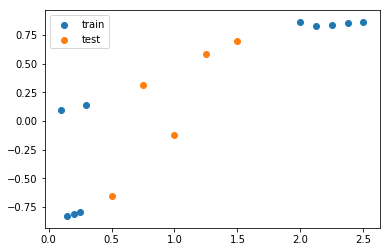

In [21]:
h_data = [d[1] for d in train_data]
predicted = [prediction(d[0], res_training.x, tn_1, tn_2) for d in train_data]

h_2 = [d[1] for d in test_data]
prd_test = [prediction(d[0], res_training.x, tn_1, tn_2) for d in test_data]

plt.scatter(h_data, predicted, label='train')
plt.scatter(h_2, prd_test, label='test')
plt.legend()